In [1]:
#### Train a single network for 3 MNIST tasks sequentially

In [1]:
# automatically reload edited modules
%load_ext autoreload


%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data

/home/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [4]:
# import class Model
from model_last import Model

In [5]:
accuracy=open("./test_acc.txt","a+")
temp_result = 0 

In [6]:
# mnist imshow convenience function
# input is a 1D array of length 784
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

# return a new mnist dataset w/ pixels randomly permuted(序列改变)
#对mnist数据集随机打乱像素值，并做了一个转置操作，产生了mnist2数据集，相当于再产生一个数据集
def permute_mnist(mnist):
    perm_inds = list(range(mnist.train.images.shape[1]))#相当于range（784）
    #print(perm_inds)
    np.random.shuffle(perm_inds)#随机打乱0-783的列表 
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2

In [7]:
# classification accuracy plotting
def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
# train/compare vanilla sgd and ewc
#非压缩用 1model
def train_task(model, num_iter, disp_freq, trainset, testsets, x, y_, keep_prob, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter//disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch = trainset.train.next_batch(100)
            model.learning_rate= sess.run(model.learning_rate1, feed_dict={model.global_: iter})
            model.train_step.run(feed_dict={x: batch[0], y_: batch[1],keep_prob:0.5})
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels,keep_prob:1}
                    test_accs[task][iter//disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    accuracy.write(str(test_accs[task][:iter // disp_freq + 1])+"\n")
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                #print(plots)
                plot_test_acc(plots)
                if l == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

                

In [8]:
#下载fashion-mnist数据集
fash_mnist=input_data.read_data_sets('data/fashion',one_hot=True)

#下载mnist数据集
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
sess = tf.InteractiveSession()

In [10]:
# define input and target placeholders
with tf.name_scope('input'):
    keep_prob = tf.placeholder(tf.float32)
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    y1_ = tf.placeholder(tf.float32,shape=[None,10])
    y11_ = tf.placeholder(tf.float32,shape = [None,10])
    y111_ = tf.placeholder(tf.float32,shape = [None,10])


In [11]:
# instantiate new model
model = Model(x, y_,y1_,y11_,y111_,keep_prob) # simple 2-layer network

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
# initialize variables
sess.run(tf.global_variables_initializer())



#### train on task A, test on task A

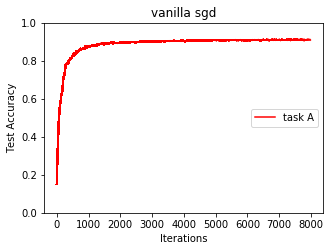

In [13]:
# training 1st task on fashion_mnist datasets
train_task(model, 8000, 20, mnist, [mnist], x, y_,keep_prob, lams=[0])

In [14]:
sess.run(model.learning_rate1, feed_dict={model.global_: 700})   

0.03757237

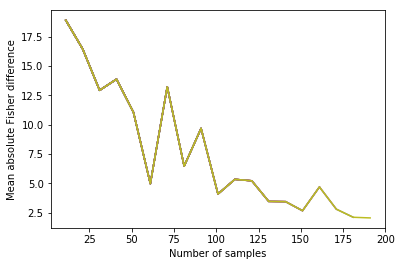

In [15]:
# Fisher information
model.compute_fisher(mnist.validation.images, sess, num_samples=200, plot_diffs=True) # use validation set for Fisher computation


In [17]:
def givemask(model,drop_connect):

    temp_accum = deepcopy(model.F_accum) 

    a_temp = np.mat(np.zeros((1,4)))
    for i in range(len(model.F_accum)):
        temp_accum[i] = np.reshape(temp_accum[i],[1,-1])
        temp_accum[i].sort() ;
        a_temp[0,i]= temp_accum[i][0,np.shape(temp_accum[i])[1]//20*drop_connect]  
    temp_accum = deepcopy(model.F_accum) 
#     for i in range(len(model.F_accum)):
#         print np.shape(model.F_accum[i])
#     for i in range(len(model.F_accum)):
#         print np.shape(temp_accum[i])        
    for i in range(len(model.F_accum)):
        #print(np.shape(temp_accum[i]))
        temp_accum[i] = np.mat(temp_accum[i])
        
#         print("fuck")
        #print(np.shape(temp_accum[i]))
        for j in range(np.shape(temp_accum[i])[0]):
            for k in range(np.shape(temp_accum[i])[1]):
                try:
                
                    if temp_accum[i][j,k] >=  a_temp[0,i] :
                        temp_accum[i][j,k] = 1 
                    else :
                        temp_accum[i][j,k] = 0;
                except:
                    print(temp_accum[i][j,k],a_temp[0,i])
#     for i in range(len(model.F_accum)):
#         result[i] = tf.multiply(model.var_list[i],temp_accum[i])

#     for i in range(len(model.F_accum)):
#         print np.shape(temp_a     ccum[i])
    
    return temp_accum
def makezero(model,mask):
    result = [0,0,0,0]
    for i in range(len(model.F_accum)):
        result[i] = tf.multiply(model.var_list[i],mask[i]) 
        
        
    sess.run(model.W1.assign(result[0]))
    sess.run(model.b1.assign(tf.reshape(tf.transpose(result[1]),[-1])))
    sess.run(model.W2.assign(result     [2]))
    sess.run(model.b2.assign(tf.reshape(tf.transpose(result[3]),[-1])))
#     print "fuck"
#     print mask[3]
#     print sess.run(model.var_list[3])
#     print sess.run(model.b2)
#     print sess.run(result[3])
#     print sess.run(tf.reshape(tf.transpose(result[3]),[-1]))
#     print "fcuk"
    
def train_task1(model, num_iter, disp_freq, trainset, testsets, x, y_, keep_prob, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        model.learning_rate = 0.05
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter//disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch = trainset.train.next_batch(50)
            if iter%20==0:
                makezero(model,mask)
            model.learning_rate= sess.run(model.learning_rate1, feed_dict={model.global_: iter})
            model.train_step.run(feed_dict={x: batch[0], y_: batch[1],keep_prob:0.5})            
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels,keep_prob:1}
                    test_accs[task][iter//disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                    temp_result = test_accs[task][iter//disp_freq]
                    c = chr(ord('A') + task)
                    accuracy.write(str(test_accs[task][:iter // disp_freq + 1])+"\n")
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                #print(plots)
                plot_test_acc(plots)
                if lams[l] == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
    return temp_result
    
    

In [18]:
#mask = givemask(model,1)
# mask =givemask(model,1)#给出mask矩
# makezero(model,mask)#加入图中

In [19]:
# #train_task1(model, 800, 40, mnist, [mnist], x, y_,keep_prob, lams=[0])
   
# trainsk1(model, 400, 100, mnist, [mnist], x, y_,keep_prob, lams=[0])_ta

0.9079999923706055


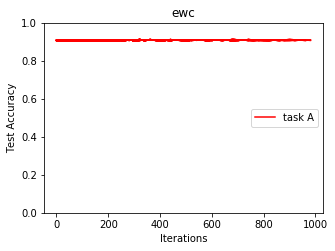

In [20]:
temp = [0]
for i in range(1,5):
    model.compute_fisher(mnist.validation.images, sess, num_samples=200, plot_diffs=False)
    mask =givemask(model,i)#给出mask矩阵
    print(i) 
    print(mask)
    makezero(model,mask)#加入图中
    model.star()
    temp.append(train_task1(model, 1000, 20, mnist, [mnist], x, y_,keep_prob, lams=[5]))
    print(temp[i]) 

#     if(temp<0.9):
#         temp = train_task1(model, 400, 50, mnist, [mnist], x, y_,keep_prob, lams=[0])
#         print temp 
#         if(temp<0.9):
#             break 


In [16]:
model.mask1 = mask 
print(model.F_accum)

NameError: name 'mask' is not defined

In [17]:
model.save_accum()#save

In [23]:
print(temp)

[0, 0.9077000021934509, 0.9074000120162964, 0.9059000015258789, 0.9079999923706055]


In [24]:
for k in temp :
    print(k)

0
0.9077000021934509
0.9074000120162964
0.9059000015258789
0.9079999923706055


In [18]:
#不压缩用
def train_task2(model, num_iter, disp_freq, trainset, testsets, x, y_,y1_, keep_prob, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore_output(sess) # reassign optimal weights from previous training session
        model.learning_rate = 0.05
        if(lams[l] == 0):
            model.self.set_vanilla_loss_output()
        else:
            model.update_ewc_loss_output(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter//disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch1 = trainset.train.next_batch(50)
            model.learning_rate= sess.run(model.learning_rate1, feed_dict={model.global_: iter})
            model.train_step_ewc_output.run(feed_dict={x: batch1[0], y1_: batch1[1],keep_prob:0.5})            
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    if task%2 == 0:
                        feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                        
                    else:
                        feed_dict={x: testsets[task].test.images, y1_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    c = chr(ord('A') + task)
                    accuracy.write(str(test_accs[task][:iter // disp_freq + 1])+"\n")
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                        
                        
                #print(plots)
                plot_test_acc(plots)
                if lams[l] == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
    return temp_result
#压缩用
def train_task22(model, num_iter, disp_freq, trainset, testsets, x, y_,y1_, keep_prob, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore_output(sess) # reassign optimal weights from previous training session
        model.learning_rate = 0.05 
        if(lams[l] == 0):
            model.set_vanilla_loss_output()
        else:
            model.update_ewc_loss_output(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter//disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch1 = trainset.train.next_batch(50)
            if iter%20==0:
                makezero(model,mask)
            model.learning_rate= sess.run(model.learning_rate1, feed_dict={model.global_: iter})
            model.train_step_ewc_output.run(feed_dict={x: batch1[0], y1_: batch1[1],keep_prob:0.5})            
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    if task%2 == 0:
                        feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                        
                    else:
                        feed_dict={x: testsets[task].test.images, y1_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    c = chr(ord('A') + task)
                    accuracy.write(str(test_accs[task][:iter // disp_freq + 1])+"\n")
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                        
                        
                #print(plots)
                plot_test_acc(plots)
                if lams[l] == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
    return temp_result

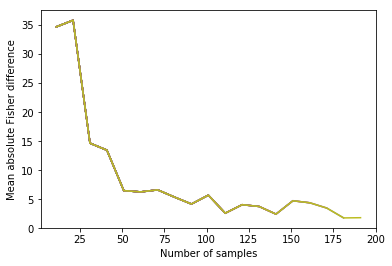

In [19]:
# Fisher information
model.compute_fisher(mnist.validation.images, sess, num_samples=200, plot_diffs=True)
# use validation set for Fisher computation


In [20]:

model.star_output()

0.7483000159263611

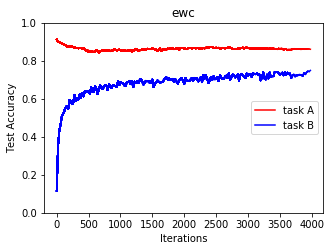

In [21]:
train_task2(model, 4000, 20, fash_mnist, [ mnist,fash_mnist], x, y_,y1_, keep_prob,lams=[5])

0.7653999924659729


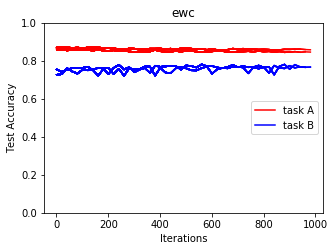

In [29]:
temp1 = [0]
for i in range(1,3):
    
    model.compute_fisher_output(fash_mnist.validation.images, sess, num_samples=200, plot_diffs=False)
    
    mask =givemask(model,i)#先根据本模型的压缩给出mask矩阵
    mask = model.or_mask(mask,model.mask1)
    
    model.get_F_accum()#加上上一个对付retrain
   
    makezero(model,mask)#加入图中
    model.star_output()
    temp1.append(train_task22(model, 1000, 20, fash_mnist, [ mnist,fash_mnist], x, y_,y1_, keep_prob,lams=[5]))
    print(temp1[i]) 
#     if temp1[i]<0.725 :
#         break 

In [30]:
model.mask2 = mask 
print(mask)


[matrix([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]), matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1.,

In [22]:
model.save_last_accum()#save

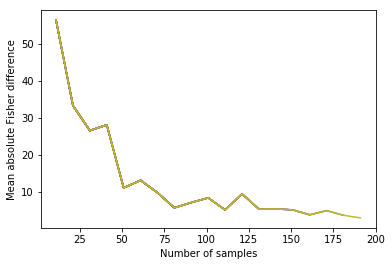

In [23]:

model.compute_fisher_output(fash_mnist.validation.images, sess, num_samples=200, plot_diffs=True)
model.get_F_accum()



#### train on task B, test on tasks A and B

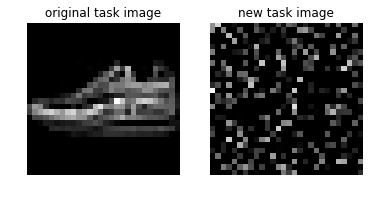

In [24]:
# permuting mnist for 2nd task
mnist2 = permute_mnist(fash_mnist)
plt.subplot(1,2,1)
mnist_imshow(fash_mnist.train.images[1])
plt.title("original task image")
plt.subplot(1,2,2)
mnist_imshow(mnist2.train.images[1])
plt.title("new task image");

In [25]:
#非压缩用
def train_task_all(model, num_iter, disp_freq, trainset, testsets, x, y_,y1_,y11_, keep_prob, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore_output1(sess) # reassign optimal weights from previous training session
        model.learning_rate = 0.05 
        if(lams[l] == 0):
            model.set_vanilla_loss_output1()
        else:
            model.update_ewc_loss_output_all(lams[l] )
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter//disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch = trainset.train.next_batch(100)
            model.learning_rate= sess.run(model.learning_rate1, feed_dict={model.global_: iter})
            model.train_step_ewc_output1.run(feed_dict={x: batch[0], y11_: batch[1],keep_prob:0.5})            
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    if task%3 == 0:
                        feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                        
                    elif task%3==1:
                        feed_dict={x: testsets[task].test.images, y1_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    elif task%3==2:
                        feed_dict={x: testsets[task].test.images, y11_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output1.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    c = chr(ord('A') + task)
                    accuracy.write(str(test_accs[task][:iter // disp_freq + 1])+"\n")
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                #print(plots)
                plot_test_acc(plots)
                if lams[l] == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
    return temp_result

#压缩用
def train_task_all1(model, num_iter, disp_freq, trainset, testsets, x, y_,y1_,y11_, keep_prob, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore_output1(sess) # reassign optimal weights from previous training session
        model.learning_rate = 0.05 
        if(lams[l] == 0):
            model.set_vanilla_loss_output1()
        else:
            model.update_ewc_loss_output_all(lams[l] )
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter//disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch = trainset.train.next_batch(100)
            if iter%20==0:
                makezero(model,mask)
            model.learning_rate= sess.run(model.learning_rate1, feed_dict={model.global_: iter})
            model.train_step_ewc_output1.run(feed_dict={x: batch[0], y11_: batch[1],keep_prob:0.5})            
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    if task%3 == 0:
                        feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                        
                    elif task%3==1:
                        feed_dict={x: testsets[task].test.images, y1_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    elif task%3==2:
                        feed_dict={x: testsets[task].test.images, y11_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output1.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    c = chr(ord('A') + task)
                    accuracy.write(str(test_accs[task][:iter // disp_freq + 1])+"\n")
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                #print(plots)
                plot_test_acc(plots)
                if lams[l] == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
    return temp_result

In [26]:
# save current optimal weights
model.star_output1()

0.7390999794006348

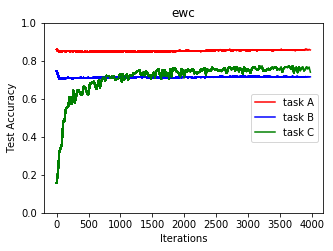

In [27]:
# training 2nd task
train_task_all(model, 4000, 20, mnist2, [mnist,fash_mnist, mnist2],x, y_,y1_,y11_,keep_prob, lams=[5])


0.7523999810218811


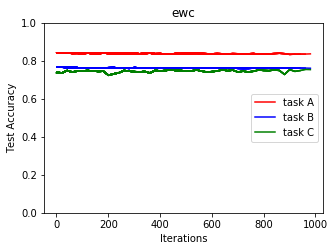

In [36]:
temp2 = [0]
for i in range(1,2):
    
    model.compute_fisher_all(mnist2.validation.images,sess,num_samples=200,plot_diffs=False)
    mask =givemask(model,i)#给出mask矩阵
    mask = model.or_mask(mask,model.mask2)
    
    
    model.get_F_accum()
    
    
    
    makezero(model,mask)#加入图中
    model.star_output1()
    temp2.append(train_task_all1(model, 1000, 20, mnist2, [mnist,fash_mnist, mnist2], x, y_,y1_,y11_,keep_prob, lams=[5]))
    print(temp2[i]) 
#     if temp2[i]<0.70 :
#         break 


In [37]:
model.mask3 = mask
print(mask)


[matrix([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]), matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1.,

In [28]:
model.save_last_accum()

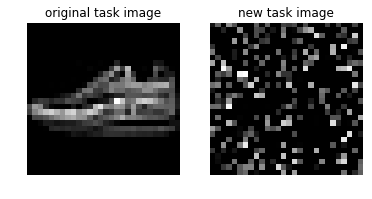

In [29]:
# permuting mnist for 2nd task
mnist3 = permute_mnist(mnist)
plt.subplot(1,2,1)
mnist_imshow(fash_mnist.train.images[1])
plt.title("original task image")
plt.subplot(1,2,2)
mnist_imshow(mnist2.train.images[1])
plt.title("new task image");

In [30]:
#非压缩用
def train_task_output3(model, num_iter, disp_freq, trainset, testsets, x, y_,y1_,y11_,y111_, keep_prob, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore_output2(sess) # reassign optimal weights from previous training session
        model.learning_rate = 0.05 
        if(lams[l] == 0):
            model.self.set_vanilla_loss_output2()
        else:
            model.update_ewc_loss_output2(lams[l] )
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter//disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch = trainset.train.next_batch(100)
            model.learning_rate= sess.run(model.learning_rate1, feed_dict={model.global_: iter})
            model.train_step_ewc_output2.run(feed_dict={x: batch[0], y111_: batch[1],keep_prob:0.5})            
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g','r+']
                for task in range(len(testsets)):
                    if task%4 == 0:
                        feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                        
                    elif task%4==1:
                        feed_dict={x: testsets[task].test.images, y1_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    elif task%4==2:
                        feed_dict={x: testsets[task].test.images, y11_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output1.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    elif task%4==3:
                        feed_dict={x:testsets[task].test.images,y111_:testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output2.eval(feed_dict=feed_dict)
                        temp_result =test_accs[task]
                    c = chr(ord('A') + task)
                    accuracy.write(str(test_accs[task][:iter // disp_freq + 1])+"\n")
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                #print(plots)
                plot_test_acc(plots)
                if lams[l] == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
    return temp_result

#压缩用
def train_task_output33(model, num_iter, disp_freq, trainset, testsets, x, y_,y1_,y11_,y111_, keep_prob, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore_output2(sess) # reassign optimal weights from previous training session
        model.learning_rate = 0.05 
        if(lams[l] == 0):
            model.self.set_vanilla_loss_output2()
        else:
            model.update_ewc_loss_output2(lams[l] )
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter//disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch = trainset.train.next_batch(100)
            if iter%20==0:
                makezero(model,mask)
            model.learning_rate= sess.run(model.learning_rate1, feed_dict={model.global_: iter})
            model.train_step_ewc_output2.run(feed_dict={x: batch[0], y111_: batch[1],keep_prob:0.5})            
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g','r+']
                for task in range(len(testsets)):
                    if task%4 == 0:
                        feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                        
                    elif task%4==1:
                        feed_dict={x: testsets[task].test.images, y1_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    elif task%4==2:
                        feed_dict={x: testsets[task].test.images, y11_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output1.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                    elif task%4==3:
                        feed_dict={x: testsets[task].test.images, y111_: testsets[task].test.labels,keep_prob:1}
                        test_accs[task][iter//disp_freq] = model.accuracy_output2.eval(feed_dict=feed_dict)
                        temp_result = test_accs[task][iter//disp_freq]
                        
                    c = chr(ord('A') + task)
                    accuracy.write(str(test_accs[task][:iter // disp_freq + 1])+"\n")
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                #print(plots)
                plot_test_acc(plots)
                if lams[l] == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
    return temp_result

In [31]:

model.compute_fisher_all(mnist2.validation.images,sess,num_samples=200,plot_diffs=False)
model.get_F_accum()

In [32]:
model.star_output2()

array([0.0803    , 0.1441    , 0.31169999, 0.45230001, 0.5115    ,
       0.54650003, 0.60259998, 0.62559998, 0.65890002, 0.68610001,
       0.70209998, 0.73259997, 0.74629998, 0.74190003, 0.75      ,
       0.75730002, 0.76819998, 0.77710003, 0.7791    , 0.78850001,
       0.79549998, 0.80059999, 0.79809999, 0.79949999, 0.80369997,
       0.8118    , 0.81440002, 0.81550002, 0.81290001, 0.81779999,
       0.81870002, 0.8233    , 0.82599998, 0.81449997, 0.83179998,
       0.83179998, 0.8312    , 0.83310002, 0.83139998, 0.83899999,
       0.83609998, 0.84109998, 0.83149999, 0.8369    , 0.84140003,
       0.83329999, 0.83380002, 0.84079999, 0.84420002, 0.84869999,
       0.85079998, 0.85039997, 0.85229999, 0.84939998, 0.84350002,
       0.85159999, 0.85299999, 0.85089999, 0.85149997, 0.85100001,
       0.85619998, 0.85680002, 0.8549    , 0.85329998, 0.85589999,
       0.85409999, 0.85399997, 0.85769999, 0.85640001, 0.86180001,
       0.85519999, 0.85839999, 0.8617    , 0.85790002, 0.86269

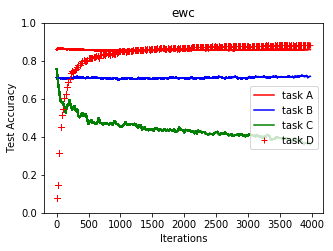

In [33]:
# training 4nd task
train_task_output3(model, 4000, 20, mnist3, [mnist,fash_mnist, mnist2,mnist3],x, y_,y1_,y11_,y111_,keep_prob, lams=[5])

